In [63]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3 #pip install timm
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np


In [64]:
def load_data():
    # 数据预处理
    transform = transforms.ToTensor()
    # 加载数据MNIST, 训练集和测试集(train=True/False), 转换为张量(附带归一化 /255), 下载数据
    train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)
    
    # 数据加载器 DataLoader, 用于将数据分批次加载, shuffle=True表示打乱数据
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False, drop_last=True)
    return train_loader, test_loader

In [65]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
     super().__init__()
     position = torch.arange(time_steps).unsqueeze(1).float()
     div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
     embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
     embeddings[:, 0::2] = torch.sin(position * div)
     embeddings[:, 1::2] = torch.cos(position * div)
     self.embeddings = embeddings
    
    def forward(self, x, t):
     embeds = self.embeddings[t].to(x.device)
     return embeds[:, :, None, None]

In [66]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
     super().__init__()
     self.relu = nn.ReLU(inplace=True)
     self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
     self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
     self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
     self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
     self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
    
    def forward(self, x, embeddings):
     x = x + embeddings[:, :x.shape[1], :, :]
     r = self.conv1(self.relu(self.gnorm1(x)))
     r = self.dropout(r)
     r = self.conv2(self.relu(self.gnorm2(r)))
     return r + x

In [67]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
     super().__init__()
     self.proj1 = nn.Linear(C, C*3)
     self.proj2 = nn.Linear(C, C)
     self.num_heads = num_heads
     self.dropout_prob = dropout_prob
    
    def forward(self, x):
     h, w = x.shape[2:]
     x = rearrange(x, 'b c h w -> b (h w) c')
     x = self.proj1(x)
     x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
     q,k,v = x[0], x[1], x[2]
     x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
     x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
     x = self.proj2(x)
     return rearrange(x, 'b h w C -> b C h w')

In [68]:
class UnetLayer(nn.Module):
    def __init__(self, upscale: bool, attention: bool, num_groups: int, dropout_prob: float, num_heads: int, C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)
        
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [69]:
class UNET(nn.Module):
    def __init__(self,
                 Channels: List = [64, 128, 256, 512, 512, 384],
                 Attentions: List = [False, True, False, False, False, True],
                 Upscales: List = [False, False, False, True, True, True],
                 num_groups: int = 32,
                 dropout_prob: float = 0.1,
                 num_heads: int = 8,
                 input_channels: int = 1,
                 output_channels: int = 1,
                 time_steps: int = 1000):
        super().__init__()
        
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        
        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        
        # Embedding layer for time steps
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        
        # Define Unet layers
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i + 1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        
        # Encoder path
        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i + 1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        
        # Decoder path
        for i in range(self.num_layers // 2, self.num_layers):
            layer = getattr(self, f'Layer{i + 1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers - i - 1]), dim=1)
        
        return self.output_conv(self.relu(self.late_conv(x)))

In [70]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)
    
    def forward(self, t):
        return self.beta[t], self.alpha[t]      

In [71]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [78]:
def train(batch_size: int = 64,
          num_time_steps: int = 1000,
          num_epochs: int = 15,
          seed: int = -1,
          ema_decay: float = 0.9999,
          lr=2e-5,
          checkpoint_path: str = None):
    
    set_seed(random.randint(0, 2**32 - 1)) if seed == -1 else set_seed(seed)
    
    train_loader,_ = load_data()
    
    # Initialize scheduler, model, optimizer, and EMA
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    
    # Load checkpoint if provided
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    
    # Define loss function
    criterion = nn.MSELoss(reduction='mean')
    
    # Training loop
    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x, _) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2, 2, 2, 2))  # Padding the image to match model input size
            t = torch.randint(0, num_time_steps, (batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size, 1, 1, 1).cuda()
            x = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)
            
            # Forward pass
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            ema.update(model)
        
        print(f'Epoch {i + 1} | Loss {total_loss / (60000 / batch_size):.5f}')
    
    # Save model checkpoint
    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, 'data/ddpm_checkpoint')

In [79]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str = None,
              num_time_steps: int = 1000,
              ema_decay: float = 0.9999):
    
    # Load checkpoint and initialize model and EMA
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    
    # Define time steps for displaying images
    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(5):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), t).cpu())
                
                # Save images at specific time steps
                if t[0] in times:
                    images.append(z)
                
                # Add noise for next step
                e = torch.randn(1, 1, 32, 32)
                z = z + (e * torch.sqrt(scheduler.beta[t]))
            
            # Final image generation step
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), [0]).cpu())

            # Display the generated image
            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            
            # Display reverse process images
            display_reverse(images)
            images = []

In [76]:
train(checkpoint_path="data/ddpm_checkpoint", lr=2e-5, num_epochs=10)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.40it/s]


Epoch 1 | Loss 0.01834


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.52it/s]


Epoch 2 | Loss 0.01815


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.51it/s]


Epoch 3 | Loss 0.01734


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.48it/s]


Epoch 4 | Loss 0.01696


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.49it/s]


Epoch 5 | Loss 0.01658


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.48it/s]


Epoch 6 | Loss 0.01602


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.48it/s]


Epoch 7 | Loss 0.01606


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.49it/s]


Epoch 8 | Loss 0.01559


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.49it/s]


Epoch 9 | Loss 0.01561


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 937/937 [00:41<00:00, 22.48it/s]


Epoch 10 | Loss 0.01552


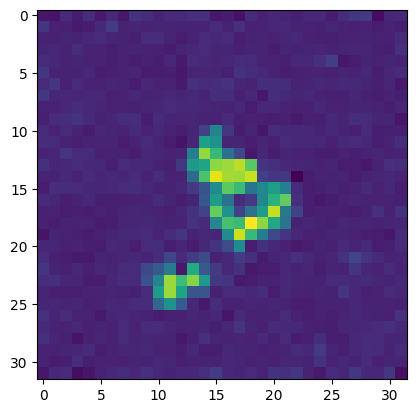

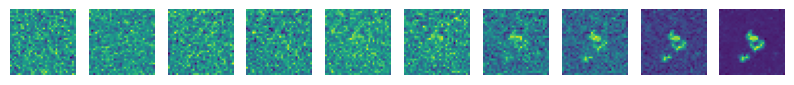

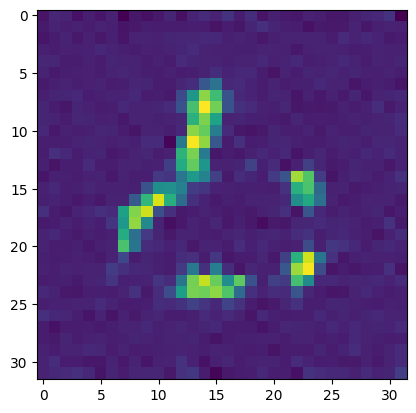

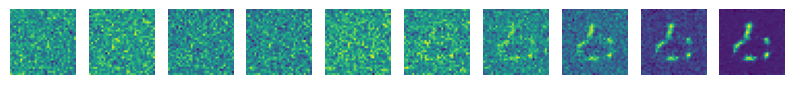

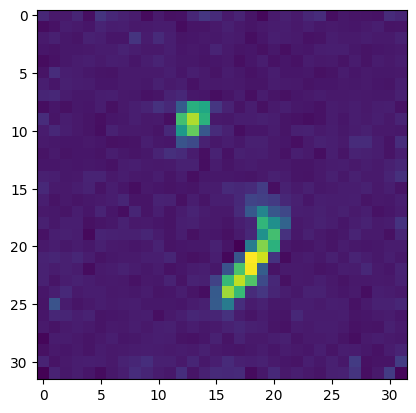

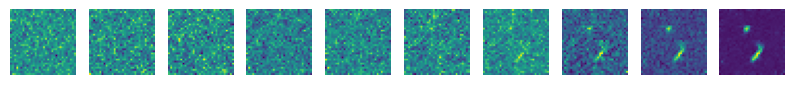

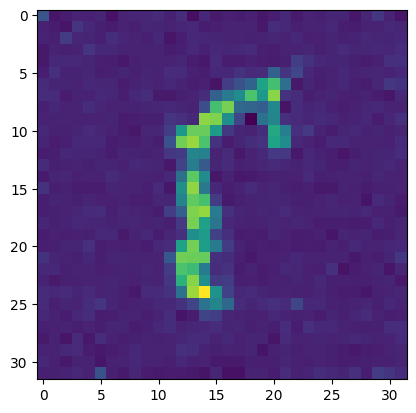

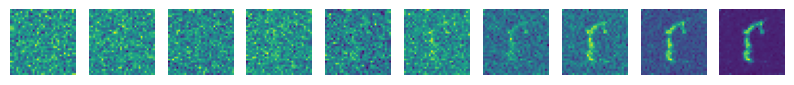

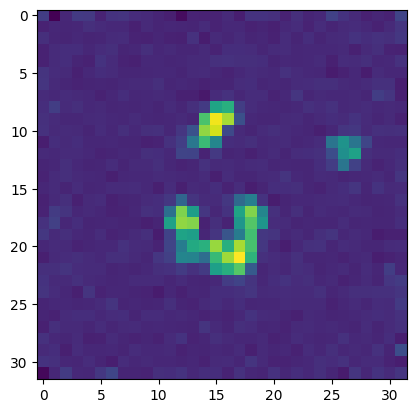

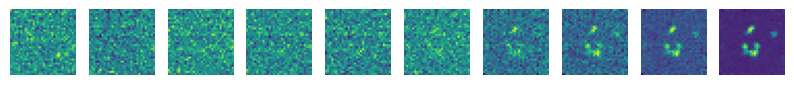

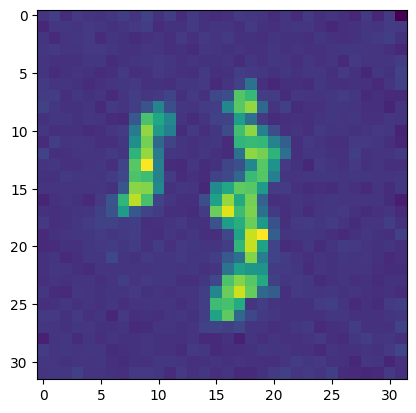

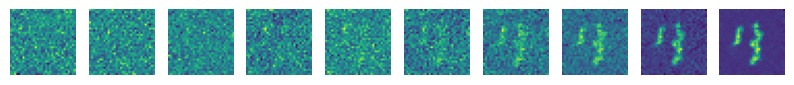

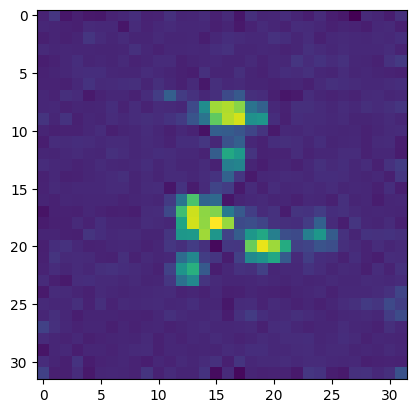

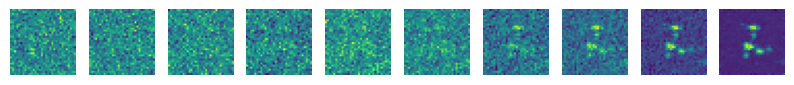

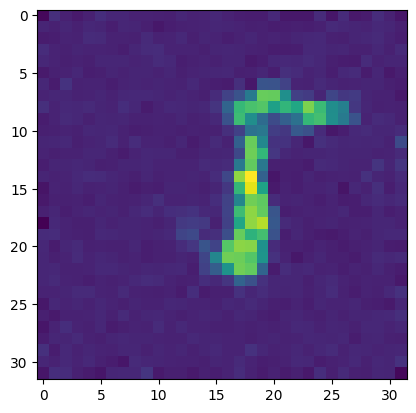

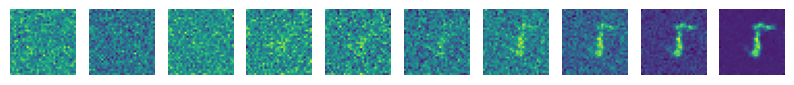

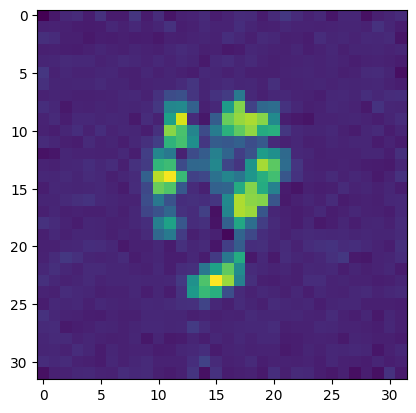

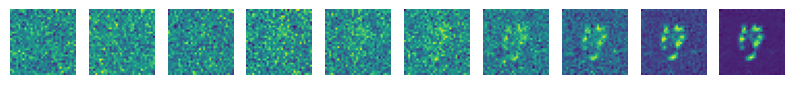

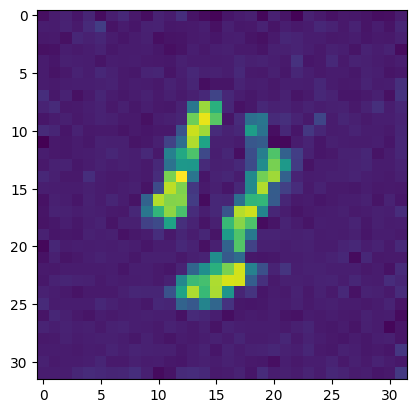

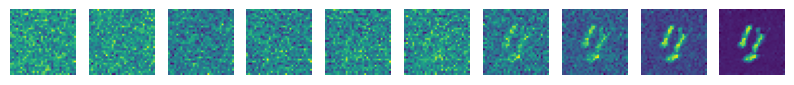

In [77]:
inference('data/ddpm_checkpoint')